# Lab. 5: Iterated local Search and Simulated Annealing

## Introduction

#### <u>The goal of this lab is to compare the behavior of Iterated Local search (ILS) and Simulated Annealing on the knapsack 0/1 problem</u>

You'll have to implement five methods:

- *Iterated Local Search*:
  - perturbation(x, k). Try different implementation of the perturbation methods. (similar to the shake method in the previous lab)
  - local_search(f, x). Try different local search strategies (FirstImprovement or BestImprovement)
- *Simulated Annealing*:
  - random_neighbor(x, i). Select a random neighbor for the solution x by doing only a few changes
  - acceptance(x, eval_x, xp, eval_xp). Return the accepted solution (x or xp) and corresponding fitness.
  - update_temperature(T, alpha). Proceed with the scheduling of the temperature parameter.
---

Getting started: The following cells contain the implementation of the methods that we will use throughout this lab, together with utilities.

#### **The Knapsack 0/1 problem** is a combinatorial problem that works as follows.

We have a bag with limited capacity L, and we have a set of items  $I=\{i_1,...,i_N\}$  Each  $i_j$  has a given volume $w_{ij}$ and a value $v_{ij}$. The goal of the optimization problem is to fill the bag with a combination of items $S$ such that the combination maximizes the total value contained by the bag while complaining with the constraint on the capacity.

In this version of the knapsack problem we can either discard or carry (at most 1) item. Thus, the search space is $\{0,1\}^{|I|}$ .

Since this is a maximization problem, we can turn it into a minimization problem by returning the opposite of the value. If a solution is not feasible (i.e., exceeds the maximum volume) the function will return a score of 0 (like an empty bag).


Assume
$$ N = \text{number of items} $$
$$ X = \{x_1, x_2, \dots, x_N\} = \text{set of items} $$
$$ v_i = \text{value of item } x_i $$
$$ w_i = \text{weight of item } x_i $$
$$ W = \text{maximum weight the knapsack can hold} $$


Then the 0/1 knapsack problem can be formulated as follows:

\begin{equation*}
  \begin{array}{lr@{}c@{}r@{}l}
    \text{maximize }   &S = \sum_{x_i \in X} v_i x_i \\
    \text{subject to } & \sum_{x_i \in X} w_i x_i \leq W \\
                       & x_i \in \{0, 1\} \forall x_i \in X \\
  \end{array}
\end{equation*}

\\

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from itertools import combinations

In [226]:
class Knapsack_0_1:

    def __init__(self):
        self._items = [
            {'name': 'apple', 'value': 1, 'volume': 2},
            {'name': 'pear', 'value': 2, 'volume': 2},
            {'name': 'banana', 'value': 2, 'volume': 2},
            {'name': 'watermelon', 'value': 5, 'volume': 10},
            {'name': 'orange', 'value': 3, 'volume': 2},
            {'name': 'avocado', 'value': 3, 'volume': 2},
            {'name': 'blueberry', 'value': 3, 'volume': 1},
            {'name': 'coconut', 'value': 4, 'volume': 3},
            {'name': 'cherry', 'value': 2, 'volume': 1},
            {'name': 'apricot', 'value': 1, 'volume': 1},
        ]
        self._BAG_CAPACITY = 10
        self.history = []
        self.values = []

    def _get_value(self, solution):
        cur_cap = self._BAG_CAPACITY
        cur_val = 0
        for i, v in enumerate(solution):
            if v == 1:
                cur_val += self._items[i]['value']
                cur_cap -= self._items[i]['volume']
            if cur_cap < 0:
                return 0
        return -cur_val

    def __call__(self, solution):
        value = self._get_value(solution)
        self.history.append(solution)
        self.values.append(value)
        return value

    def trend(self):
        plt.figure()
        plt.plot(self.values)
        plt.show()

## Exercises

### Iterated Local Search
**Finish the implementation of the algorithm first**, then answer the question later on.

In [229]:
def iteratedLocalSearch(f, x0, ls_max):
    """
    Seeks for the minimum of the function by means of the Iterated local search algorithm.

    - f: the function to optimize
    - x0: the initial point
    - ls_max: the max number of local search
    """
    
    def perturbation_k(x,k):
        xp = copy.deepcopy(x)
        # Generate k unique random indices to flip
        if k >= len(x):
            k = len(x) - 1
        flip_indices = np.random.choice(len(x) ,  size=k, replace=False)
        # Flip the selected bits
        for index in flip_indices:
            xp[index] = 1 - xp[index]

        return xp

    def perturbation(x, k):
        
        # small k: small changes, slower exploration
        # large k: drastic changes, faster exploration

        # xp = perturbation_k(x, len(x) - 1)                  # max 
        xp = perturbation_k(x, int(len(x) / 2))           # middle 
        # xp = perturbation_k(x, 1)                         # min 

        return xp

    def acceptance_criterion(f, x, xs, k):
        if f(xs) < f(x):
            x = xs
            k = 1
        else:
            k += 1
        return x, k
    
    

    def best_improvement(f,x):
        best_x = copy.deepcopy(x)
        best_value = f(best_x)
        for i in range(len(x)):
            neighbor = perturbation(x, i + 1)

            # Evaluate the objective function value of the neighbor
            xp = f(neighbor)

            # Update the current best solution if the neighbor is better
            if xp < best_value:
                best_x = neighbor
                best_value = xp
                
        return best_x
                
                
    def first_improvement(f,x):
        best_x = copy.deepcopy(x)
        best_value = f(best_x)
        for i in range(len(x)):
            neighbor = perturbation(x, i + 1)

            # Evaluate the objective function value of the neighbor
            xp = f(neighbor)

            # Update the current best solution if the neighbor is better
            if xp < best_value:
                return neighbor
                
        return best_x

    def local_search(f, x):
        # xs = best_improvement(f,x)
        xs = first_improvement(f,x)
        return xs

    n = 0
    x = np.array(x0, int)
    best = x
    bestval = f(x)

    i = 0
    while i < ls_max:
        xp = perturbation(x, i)
        xs = local_search(f, xp)
        x, i = acceptance_criterion(f, x, xs, i)

        # Store the best
        curval = f(x)
        if curval < bestval:
            bestval = curval
            best = x
        i += 1
    return best

#### Questions:
- how does the starting point influence the search process?
- how does the ls_max parameter affect the quality of the result?
- how does the perturbation of the solutions affect:
    - quality of the search?
    - velocity of the search?


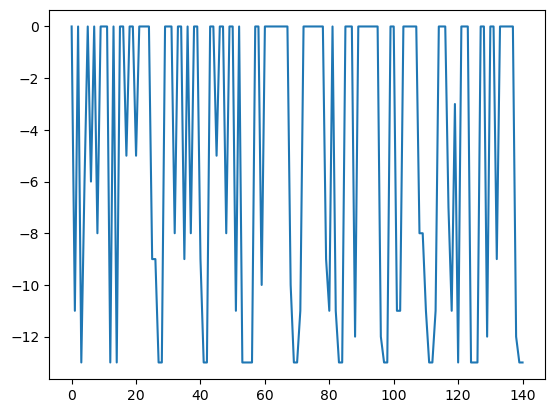

In [338]:
func = Knapsack_0_1()
iteratedLocalSearch(func, [0] * len(func._items), 20)



# initial_point = np.random.randint(2, size=len(func._items))
# print(initial_point)
# iteratedLocalSearch(func, initial_point, 20)
func.trend()


### Simulated Annealing
**Finish the implementation of the algorithm first**, then answer the question later on.

In [45]:
import math

def simulatedAnnealing(f, x0, iter, T, k, alpha):
    """
    Seeks for the minimum of the function by means of the Simulated Annealing algorithm.

    - f: the function to optimize
    - x0: the initial point
    - iter: number of temperature update
    - T: Initial high temperature
    - k: Number of iterations at fixed temperature
    - alpha: cooling scheduling parameter
    """

    def random_neighbor(x, i):
        """
        Generates a random neighbor for the solution x.

        - x: starting point
        - i: number of changes to be made

        Returns:
        - x': the random sampled from the neighborhood
        """
        
        xp = copy.deepcopy(x)
        
        indexes = np.random.choice(len(x), i, replace=False) # random indexes to flip
        for index in indexes:
            xp[index] = 1 - xp[index] 
        
        # assert False, "Random Neighbor generator has to be implemented"
        return xp

    def acceptance(x, eval_x, xp, eval_xp):
        """
        Returns the solution and fitness accepted between x and xp.

        - x: current solution
        - eval_x: eval of solution x
        - xp: new solution
        - eval_xp: eval of solution xp

        Returns:
        - x: new current solution
        - eval_x: eval of new solution x
        """
        
        
        if eval_xp < eval_x:
            return xp, eval_xp
        else:
            return x, eval_x

    def update_temperature(T, alpha):
        """
        Updates the temperature T and the parameter alpha.

        - T: temperature
        - alpha: cooling scheduling parameter

        Returns:
        - T: updated temperature
        - alpha: cooling scheduling parameter
        """
        T *= alpha
        return T, alpha

    x = np.array(x0)
    for i in range(iter):
        for fix_temp in range(k):
            eval_x = f(x)
            xp = random_neighbor(x, fix_temp)
            eval_xp = f(xp)
            x, eval_x = acceptance(x, eval_x, xp, eval_xp)
        T, alpha = update_temperature(T, alpha)

    return x, eval_x

In [327]:
# MY VERSION OF simulatedAnnealing
# first version:    
    # Acceptance criterion solely based on whether the evaluation of the new solution is better than the current one.
    # Doesn't include probability calculation for acceptance based on the Metropolis criterion.
# my version:
    # Includes the Metropolis criterion for acceptance, which involves generating a random number and comparing it with the probability ratio.
    # Adjusts the temperature inside the acceptance function, considering its use in the probability calculation.

import math

def simulatedAnnealing2(f, x0, iter, T, k, alpha):
    """
    Seeks for the minimum of the function by means of the Simulated Annealing algorithm.

    - f: the function to optimize
    - x0: the initial point
    - iter: number of temperature update
    - T: Initial high temperature
    - k: Number of iterations at fixed temperature
    - alpha: cooling scheduling parameter
    """

    def random_neighbor(x, i):
        """
        Generates a random neighbor for the solution x.

        - x: starting point
        - i: number of changes to be made

        Returns:
        - x': the random sampled from the neighborhood
        """
        
        xp = copy.deepcopy(x)
        
        indexes = np.random.choice(len(x), i, replace=False) # random indexes to flip
        for index in indexes:
            xp[index] = 1 - xp[index] 
        
        return xp

    def acceptance(x, eval_x, xp, eval_xp, T):
        """
        Returns the solution and fitness accepted between x and xp.

        - x: current solution
        - eval_x: eval of solution x
        - xp: new solution
        - eval_xp: eval of solution xp

        Returns:
        - x: new current solution
        - eval_x: eval of new solution x
        """
        
        if eval_xp < eval_x:
            return xp, eval_xp
        else: 
            r = np.random.uniform(0, 1) # Randomly draw from uniform distribution
            
            p = math.exp((-(eval_xp - eval_x)) / T)
            
            if p >= r:
                return xp, eval_xp
            else:
                return x, eval_x

    def update_temperature(T, alpha):
        """
        Updates the temperature T and the parameter alpha.

        - T: temperature
        - alpha: cooling scheduling parameter

        Returns:
        - T: updated temperature
        - alpha: cooling scheduling parameter
        """
        T *= alpha
        return T, alpha

    x = np.array(x0)
    for i in range(iter):
        for fix_temp in range(k):
            eval_x = f(x)
            xp = random_neighbor(x, int(T))
            eval_xp = f(xp)
            x, eval_x = acceptance(x, eval_x, xp, eval_xp, T)
        T, alpha = update_temperature(T, alpha)

    return x, eval_x

#### Questions:
- how does the starting point influence the search process?
- how does the initial temperature affect the quality of the result?
- how does the selection of the neighborhood affect:
    - quality of the search?
    - velocity of the search?
- How does the acceptance policy influence the search?
- How does the update of the temparture affect the search?


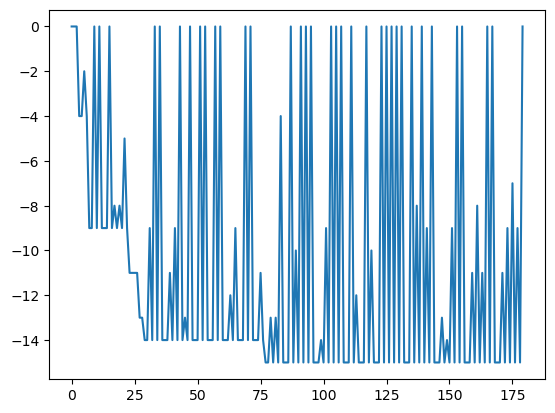

In [330]:
func = Knapsack_0_1() 
# x, eval_x = simulatedAnnealing(func, [0] * len(func._items), 10, 10, 10, 0.1)

#initial_point = np.random.randint(2, size=len(func._items)) 
# print(initial_point)
x, eval_x = simulatedAnnealing(func, [0] * len(func._items), 15, 8, 6, 0.8) # (f, x0, iter, T, k, alpha)

func.trend()



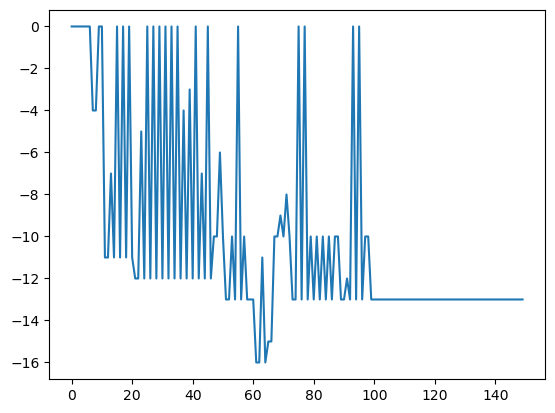

In [344]:
func2 = Knapsack_0_1() 
x, eval_x = simulatedAnnealing2(func2, [0] * len(func2._items), 15, 8, 5, 0.8) # (f, x0, iter, T, k, alpha)
func2.trend()


### Final questions:
Iterated local search, variable neighbor search, and simulated annealing are very similar optimization algorithms.
Considering what was seen in this lab and the previous one, answer these questions:
 - Is there a "more efficient" algorithm?
 - How do the different parameters affect the search, and do they affect the choice of one algorithm to respect the others?